In [3]:
from rlcard.utils.utils import remove_illegal
import numpy as np
import random
import collections
import enum
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import rlcard
import os
import datetime
import pickle
from rlcard.agents.nfsp_agent import ReservoirBuffer, DQNAgent
from rlcard.agents import RandomAgent
from rlcard.utils import get_device, set_seed, tournament, reorganize, Logger, plot_curve, remove_illegal


class CFRAgent:
    def __init__(self, env, model_name, model_path='./cfr_model'):
        self.env = env
        self.model_path = model_path
        self.strategy = collections.defaultdict(list)
        self.average_strategy = collections.defaultdict(np.array)
        self.regrets = collections.defaultdict(np.array)
        self.iteration = 0
        self.use_raw = False
        self.model_name = model_name
    
    def save(self):
        with open(os.path.join('./', self.model_path, self.model_name + '-cfr-' + 'avg-strategy.pkl'), 'wb') as f:
            pickle.dump(agent.average_strategy, f)

        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'strategy.pkl'), 'wb') as f:
            pickle.dump(agent.strategy, f)

        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'regrets.pkl'), 'wb') as f:
            pickle.dump(agent.regrets, f)
            
    def load(self):
        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'avg-strategy.pkl', 'w')) as f:
            self.average_strategy = pickle.load(f)
        
        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'strategy.pkl', 'w')) as f:
            self.strategy = pickle.load(f)
                  
        with open(os.path.join(self.model_path, self.model_name + '-cfr-' + 'regrets.pkl', 'w')) as f:
            self.regrets = pickle.load(f)

    def get_state(self, player_id):
        state = self.env.get_state(player_id)
        
        # returns a tuple, current observation encoded as a string and a list of possible actions
        return state['obs'].tostring(), list(state['legal_actions'].keys())

    
    def train(self):
        # train every player
        self.iteration += 1
        self.env.reset()
        
        for player_id in range(self.env.num_players):
            reach_probs = np.ones(self.env.num_players)
            self.cfr(reach_probs, player_id)
        
        self.update_strategy()
            
    def get_strategy_for_actions(self, obs, actions, strategy):
        if obs not in strategy.keys():
            # initialize to uniform distribution
            action_probs = np.array([1.0/self.env.num_actions for _ in range(self.env.num_actions)]) # todo refactor this
            self.strategy[obs] = action_probs
        else:
            action_probs = strategy[obs]
        action_probs = remove_illegal(action_probs, actions)
        return action_probs

    def update_strategy(self):
        ''' Update policy based on the current regrets
        '''
        for obs in self.regrets:
            self.strategy[obs] = self.regret_matching(obs)
            
    def eval_step(self, state):
        ''' Given a state, predict action based on average policy
        Args:
            state (numpy.array): State representation
        Returns:
            action (int): Predicted action
            info (dict): A dictionary containing information
        '''
        probs = self.get_strategy_for_actions(state['obs'].tostring(), list(state['legal_actions'].keys()), self.average_strategy)
        action = np.random.choice(len(probs), p=probs)

        info = {}
        info['probs'] = {state['raw_legal_actions'][i]: float(probs[list(state['legal_actions'].keys())[i]]) for i in range(len(state['legal_actions']))}

        return action, info

    
    def regret_matching(self, obs):
        regret = self.regrets[obs]
        positive_regret_sum = sum([r for r in regret if r > 0])
        
        action_probs = np.zeros(self.env.num_actions)
        if positive_regret_sum > 0:
            for action in range(self.env.num_actions):
                action_probs[action] = max(0.0, regret[action] / positive_regret_sum)
        else:
            for action in range(self.env.num_actions):
                action_probs[action] = 1.0 / self.env.num_actions
        return action_probs

        
    def cfr(self, reach_probs, player_id):
        if self.env.is_over():
            return self.env.get_payoffs()
        
        current_player = self.env.get_player_id()
        
        action_utilities = {} # expected payoff for every action?
        infostate_utility = np.zeros(self.env.num_players) # get a handle on this, counterfactual reach probability?
        
        obs, legal_actions = self.get_state(current_player)
        
        # get the strategy for possible actions
        action_probs = self.get_strategy_for_actions(obs, legal_actions, self.strategy)
        
        for action in legal_actions:
            # recalculate reach probability for this action
            action_prob = action_probs[action]
            new_reach_probs = reach_probs.copy()
            new_reach_probs[current_player] *= action_prob
            
            # traverse util you reach game node z, this will terminate at env.is_over()
            self.env.step(action)
            utility = self.cfr(new_reach_probs, player_id)
            self.env.step_back()
            
            # counterfactual reach probability equals the sum of all reach probabilities
            infostate_utility += action_prob * utility
            action_utilities[action] = utility
            
        if not current_player == player_id:
            return infostate_utility
        
        player_prob = reach_probs[current_player]
        counterfactual_prob = (np.prod(reach_probs[:current_player]) *
                                np.prod(reach_probs[current_player + 1:]))
        player_state_utility = infostate_utility[current_player]
        
        # initialize records if they don't exist
        if obs not in self.regrets:
            self.regrets[obs] = np.zeros(self.env.num_actions)
        if obs not in self.average_strategy:
            self.average_strategy[obs] = np.zeros(self.env.num_actions)
        
        # calculate counterfactual regret for every action
        for action in legal_actions:
            action_prob = action_probs[action]
            
            # counterfactual regret is the utility of the action taking by the player - total utility of all actions 
            regret = counterfactual_prob * (action_utilities[action][current_player] - player_state_utility)
            self.regrets[obs][action] += regret
            self.average_strategy[obs][action] += self.iteration * player_prob * action_prob
        return infostate_utility
    



class AveragePolicyAgent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(self.env.state_shape[0][0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, self.env.num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, dim=-1)


class AveragePolicyAgent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(self.env.state_shape[0][0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, self.env.num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, dim=-1)


class NFSPAgent:
    def __init__(self, env, device):
        self.use_raw = False
        self._device = device
        
        self.eta = 0.1
        
        self.sample_size = 32
        
        self._rl_agent = DQNAgent(
            state_shape=env.state_shape[0],
            num_actions=env.num_actions,
            mlp_layers=[64, 64],
            device=device)
        self._m_sl = ReservoirBuffer(20000)
        self._avg_policy_agent = AveragePolicyAgent(env)
        self._avg_policy_agent.to(device)
        self._avg_policy_optimizer = torch.optim.Adam(self._avg_policy_agent.parameters(), lr=0.005)
        self.device = device
        self.model_path = './models'
        self.epochs = 0
        
    def eval_step(self, state):

        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())
        if np.random.rand() < self.eta:
            action, info = self._rl_agent.eval_step(state)
        else:
            action_probs = self._get_action_probs_from_policy(obs)
            action_probs = remove_illegal(action_probs, legal_actions)
            action = np.random.choice(len(action_probs), p=action_probs)
            info = {}
            info['probs'] = {state['raw_legal_actions'][i]: float(action_probs[list(state['legal_actions'].keys())[i]]) for i in range(len(state['legal_actions']))}
        
        return action, info
    
    def save(self, model_name):
        torch.save({
            'avg_policy': self._avg_policy_agent.state_dict(),
            'q_policy_estimator': self._rl_agent.q_estimator.qnet.state_dict(),
            'q_target_estimator': self._rl_agent.target_estimator.qnet.state_dict()
        }, self.model_path + '/' + model_name)

    def load(self, model_name):
        checkpoint = torch.load(self.model_path + '/' + model_name)
        self._avg_policy_agent.load_state_dict(checkpoint['avg_policy'])
        self._rl_agent.q_estimator.qnet.load_state_dict(checkpoint['q_policy_estimator'])
        self._rl_agent.target_estimator.qnet.load_state_dict(checkpoint['q_target_estimator'])
    
    def step(self, state):

        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())
        if np.random.rand() < self.eta:
            # make the rl agent act

            action = self._rl_agent.step(state)
            one_hot = np.zeros(env.num_actions)
            one_hot[action] = 1

            self._m_sl.add((obs, one_hot))
        else:
            # avg policy agent
            action_probs = self._get_action_probs_from_policy(obs)
            action_probs = remove_illegal(action_probs, legal_actions)
            action = np.random.choice(len(action_probs), p=action_probs)

        return action
    
    def train_avg_policy(self):
        if len(self._m_sl) < self.sample_size:
            return None
        
        sample = self._m_sl.sample(self.sample_size)
        
        self._avg_policy_agent.zero_grad()
        self._avg_policy_agent.eval()
        
        infostates = []
        action_probs = []
        for transition in sample:
            infostates.append(transition[0])
            action_probs.append(transition[1])
        
        infostates = torch.from_numpy(np.array(infostates)).float().to(self.device)
        eval_action_probs = torch.from_numpy(np.array(action_probs)).float().to(self.device)
        #eval_action_probs = eval_action_probs.long()
        log_action_probs = self._avg_policy_agent(infostates)
        #criterion = nn.MSELoss()
        #loss = criterion(log_action_probs, eval_action_probs)
        loss = -(eval_action_probs * log_action_probs).sum(dim=-1).mean()
        loss.backward()
        
        self._avg_policy_optimizer.step()
        self._avg_policy_agent.eval()
        loss_total = loss.item()
        return loss_total
    
    def _get_action_probs_from_policy(self, obs):
        obs = torch.from_numpy(obs).float().to(self.device)
        
        with torch.no_grad():
            action_probs = self._avg_policy_agent(obs)
        
        action_probs = action_probs.cpu().numpy()
        return np.exp(action_probs)


In [4]:
EPISODES = 200000
EVALUATE_EVERY = 1000
EVALUATION_GAMES = 2000
GAME = 'limit-holdem'

# Training

--> Running on the GPU

----------------------------------------
  timestep     |  5
  reward       |  0.2255
----------------------------------------
INFO - Step 100, rl-loss: 5.499166488647461
INFO - Copied model parameters to target network.
INFO - Step 1100, rl-loss: 0.8327940702438354
INFO - Copied model parameters to target network.
INFO - Step 1491, rl-loss: 1.21543717384338386
----------------------------------------
  timestep     |  8555
  reward       |  1.33475
----------------------------------------
INFO - Step 2100, rl-loss: 6.25836086273193475
INFO - Copied model parameters to target network.
INFO - Step 2990, rl-loss: 0.47045207023620605
----------------------------------------
  timestep     |  20303
  reward       |  1.72525
----------------------------------------
INFO - Step 3100, rl-loss: 1.31423234939575246
INFO - Copied model parameters to target network.
INFO - Step 4100, rl-loss: 1.01547574996948246
INFO - Copied model parameters to target network.
INFO - Step

INFO - Step 42100, rl-loss: 4.2544755935668945
INFO - Copied model parameters to target network.
INFO - Step 43100, rl-loss: 1.5055673122406006
INFO - Copied model parameters to target network.
INFO - Step 43995, rl-loss: 12.999137878417969
----------------------------------------
  timestep     |  308415
  reward       |  2.30525
----------------------------------------
INFO - Step 44100, rl-loss: 5.3570933341979982
INFO - Copied model parameters to target network.
INFO - Step 45100, rl-loss: 2.1265368461608887
INFO - Copied model parameters to target network.
INFO - Step 46069, rl-loss: 9.6735239028930666
----------------------------------------
  timestep     |  322605
  reward       |  2.391
----------------------------------------
INFO - Step 46100, rl-loss: 9.1836271286010749
INFO - Copied model parameters to target network.
INFO - Step 47100, rl-loss: 6.22384119033813555
INFO - Copied model parameters to target network.
INFO - Step 48100, rl-loss: 10.767949104309082
INFO - Copie

INFO - Step 88100, rl-loss: 2.5985951423645028
INFO - Copied model parameters to target network.
INFO - Step 88509, rl-loss: 3.4647524356842042
----------------------------------------
  timestep     |  611055
  reward       |  2.448
----------------------------------------
INFO - Step 89100, rl-loss: 1.7352620363235474
INFO - Copied model parameters to target network.
INFO - Step 90100, rl-loss: 2.6942155361175537
INFO - Copied model parameters to target network.
INFO - Step 90740, rl-loss: 2.6382884979248047
----------------------------------------
  timestep     |  625624
  reward       |  2.45425
----------------------------------------
INFO - Step 91100, rl-loss: 2.8906617164611816
INFO - Copied model parameters to target network.
INFO - Step 92100, rl-loss: 2.6652073860168457
INFO - Copied model parameters to target network.
INFO - Step 92839, rl-loss: 15.149545669555664
----------------------------------------
  timestep     |  640013
  reward       |  2.43625
------------------

INFO - Step 133100, rl-loss: 1.6475315093994143
INFO - Copied model parameters to target network.
INFO - Step 133548, rl-loss: 1.4499040842056274
----------------------------------------
  timestep     |  915967
  reward       |  2.352
----------------------------------------
INFO - Step 134100, rl-loss: 9.8379335403442381
INFO - Copied model parameters to target network.
INFO - Step 135100, rl-loss: 3.0705165863037115
INFO - Copied model parameters to target network.
INFO - Step 135721, rl-loss: 7.5787291526794435
----------------------------------------
  timestep     |  930221
  reward       |  2.45175
----------------------------------------
INFO - Step 136100, rl-loss: 2.3724312782287598
INFO - Copied model parameters to target network.
INFO - Step 137100, rl-loss: 1.6814334392547607
INFO - Copied model parameters to target network.
INFO - Step 137895, rl-loss: 1.6464548110961914
----------------------------------------
  timestep     |  944615
  reward       |  2.4755
-----------

INFO - Step 178100, rl-loss: 4.7651586532592773
INFO - Copied model parameters to target network.
INFO - Step 178128, rl-loss: 4.3022866249084475
----------------------------------------
  timestep     |  1220392
  reward       |  2.51725
----------------------------------------
INFO - Step 179100, rl-loss: 2.1279506683349615
INFO - Copied model parameters to target network.
INFO - Step 180100, rl-loss: 1.7433394193649292
INFO - Copied model parameters to target network.
INFO - Step 180220, rl-loss: 2.1901507377624517
----------------------------------------
  timestep     |  1235283
  reward       |  2.50575
----------------------------------------
INFO - Step 181100, rl-loss: 15.929611206054688
INFO - Copied model parameters to target network.
INFO - Step 182100, rl-loss: 13.388154983520508
INFO - Copied model parameters to target network.
INFO - Step 182351, rl-loss: 4.1177721023559577
----------------------------------------
  timestep     |  1249604
  reward       |  2.51025
-----

INFO - Step 223100, rl-loss: 6.3256163597106933
INFO - Copied model parameters to target network.
INFO - Step 223147, rl-loss: 2.0075135231018066
----------------------------------------
  timestep     |  1527597
  reward       |  2.486
----------------------------------------
INFO - Step 224100, rl-loss: 3.5823602676391664
INFO - Copied model parameters to target network.
INFO - Step 225100, rl-loss: 9.0283241271972669
INFO - Copied model parameters to target network.
INFO - Step 225290, rl-loss: 10.206042289733887
----------------------------------------
  timestep     |  1542307
  reward       |  2.29625
----------------------------------------
INFO - Step 226100, rl-loss: 1.4206266403198242
INFO - Copied model parameters to target network.
INFO - Step 227100, rl-loss: 2.1359941959381104
INFO - Copied model parameters to target network.
INFO - Step 227437, rl-loss: 2.8660116195678718
----------------------------------------
  timestep     |  1556746
  reward       |  2.45975
-------

INFO - Step 268100, rl-loss: 6.0747919082641672
INFO - Copied model parameters to target network.
INFO - Step 268461, rl-loss: 4.3296713829040538
----------------------------------------
  timestep     |  1832412
  reward       |  2.32175
----------------------------------------
INFO - Step 269100, rl-loss: 4.8401422500610357
INFO - Copied model parameters to target network.
INFO - Step 270100, rl-loss: 7.5411443710327152
INFO - Copied model parameters to target network.
INFO - Step 270627, rl-loss: 4.6867399215698247
----------------------------------------
  timestep     |  1846977
  reward       |  2.4635
----------------------------------------
INFO - Step 271100, rl-loss: 3.7690229415893555
INFO - Copied model parameters to target network.
INFO - Step 272100, rl-loss: 3.4097898006439216
INFO - Copied model parameters to target network.
INFO - Step 272751, rl-loss: 2.5003168582916265
----------------------------------------
  timestep     |  1861508
  reward       |  2.45775
------

INFO - Step 313100, rl-loss: 1.7543039321899414
INFO - Copied model parameters to target network.
INFO - Step 313774, rl-loss: 18.622520446777344
----------------------------------------
  timestep     |  2137869
  reward       |  2.22275
----------------------------------------
INFO - Step 314100, rl-loss: 1.6193618774414062
INFO - Copied model parameters to target network.
INFO - Step 315100, rl-loss: 1.8805166482925415
INFO - Copied model parameters to target network.
INFO - Step 315896, rl-loss: 7.4126920700073248
----------------------------------------
  timestep     |  2152399
  reward       |  2.636
----------------------------------------
INFO - Step 316100, rl-loss: 9.0732278823852546
INFO - Copied model parameters to target network.
INFO - Step 317100, rl-loss: 2.6504502296447754
INFO - Copied model parameters to target network.
INFO - Step 317964, rl-loss: 2.3748230934143066
----------------------------------------
  timestep     |  2166939
  reward       |  2.5445
--------

INFO - Step 358100, rl-loss: 2.4280960559844977
INFO - Copied model parameters to target network.
INFO - Step 358374, rl-loss: 1.1578598022460938
----------------------------------------
  timestep     |  2444595
  reward       |  2.24925
----------------------------------------
INFO - Step 359100, rl-loss: 20.458215713500977
INFO - Copied model parameters to target network.
INFO - Step 360100, rl-loss: 2.9030370712280273
INFO - Copied model parameters to target network.
INFO - Step 360453, rl-loss: 12.034994125366211
----------------------------------------
  timestep     |  2458880
  reward       |  2.65075
----------------------------------------
INFO - Step 361100, rl-loss: 1.8052755594253541
INFO - Copied model parameters to target network.
INFO - Step 362100, rl-loss: 9.2747669219970764
INFO - Copied model parameters to target network.
INFO - Step 362582, rl-loss: 5.2602415084838871
----------------------------------------
  timestep     |  2473633
  reward       |  2.534
-------

INFO - Step 403100, rl-loss: 1.6216375827789307
INFO - Copied model parameters to target network.
INFO - Step 403812, rl-loss: 2.3629374504089355
----------------------------------------
  timestep     |  2751483
  reward       |  2.43225
----------------------------------------
INFO - Step 404100, rl-loss: 6.9272098541259774
INFO - Copied model parameters to target network.
INFO - Step 405100, rl-loss: 2.8308458328247073
INFO - Copied model parameters to target network.
INFO - Step 405984, rl-loss: 33.580238342285156
----------------------------------------
  timestep     |  2766244
  reward       |  2.62975
----------------------------------------
INFO - Step 406100, rl-loss: 4.9637560844421397
INFO - Copied model parameters to target network.
INFO - Step 407100, rl-loss: 3.0690469741821293
INFO - Copied model parameters to target network.
INFO - Step 408098, rl-loss: 23.968807220458984
----------------------------------------
  timestep     |  2780892
  reward       |  2.503
-------

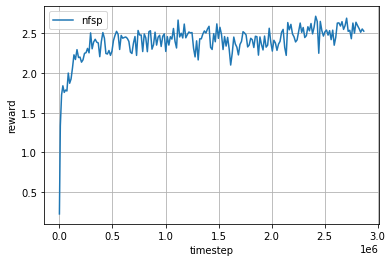

In [6]:
device = get_device()
# from rlcard.agents import NFSPAgent

env = rlcard.make(GAME, config={'seed': 0})

nfsp = NFSPAgent(env, device)
nfsp.eta = 0.9
# nfsp = NFSPAgent(num_actions=env.num_actions,
#                           state_shape=env.state_shape[0],
#                           hidden_layers_sizes=[64,64],
#                           q_mlp_layers=[64,64],
#                           device=device)

env.set_agents([nfsp, RandomAgent(num_actions=env.num_actions)])

# one episode
sl_loss = []
with Logger(f'./{GAME}-nfsp') as logger:
    for i in range(EPISODES):
        trajectories, payoffs = env.run(is_training=True) # requires a step method. Will populate the transition buffer m_sl
        trajectories = reorganize(trajectories, payoffs)

        for ts in trajectories[0]:
            #(state, action, reward, next_state, done) = tuple(ts)
            nfsp._rl_agent.feed(ts) # train the rl agent, populate the _m_rl buffer
            loss = nfsp.train_avg_policy()
            #nfsp.feed(ts)
        
#         nfsp.epochs += 1
        if i % EVALUATE_EVERY == 0:
            sl_loss.append(loss)
            logger.log_performance(env.timestep, tournament(env, EVALUATION_GAMES)[0])
        
        if i % 100000 == 0:
            nfsp.save('nfsp')
            
        
            
    csv_path, fig_path = logger.csv_path, logger.fig_path
    
plot_curve(csv_path, fig_path, 'nfsp')

In [7]:
nfsp.save('nfsp')

In [12]:
env = rlcard.make(GAME)

from rlcard.models.limitholdem_rule_models import LimitholdemRuleAgentV1

rule_agent = LimitholdemRuleAgentV1()

def evaluate_games(a1, a2, env):
    env.set_agents([a1, a2])
    a1_wins = 0
    a2_wins = 0
    ties = 0
    episode_count = 0
    while episode_count != EVALUATION_GAMES:
        trajectories, payoffs = env.run(is_training=False)
        if len(trajectories[0]) != 0:
            final_state = trajectories[0][-1]
            action_record = final_state['action_record']
            state = final_state['raw_obs']
            _action_list = []
            for i in range(1, len(action_record)+1):
                """
                if action_record[-i][0] == state['current_player']:
                    break
                """
                _action_list.insert(0, action_record[-i])

        if payoffs[0] > 0:
            a1_wins += 1
        elif payoffs[0] == 0:
            ties += 1
        else:
            a2_wins += 1

        episode_count += 1
    
    return a1_wins, a2_wins, ties


print(f"rule wins, nfsp wins, ties = {evaluate_games(rule_agent, nfsp, env)}")

rule wins, nfsp wins, ties = (167, 1831, 2)


In [13]:
from rlcard.agents import RandomAgent
env = rlcard.make(GAME)

random_agent = RandomAgent(num_actions=env.num_actions)
print(f"random wins, nfsp wins, ties = {evaluate_games(random_agent, nfsp, env)}")

random wins, nfsp wins, ties = (98, 1895, 7)


In [20]:
from rlcard.agents import LimitholdemHumanAgent as HumanAgent
from rlcard.utils.utils import print_card

env = rlcard.make('limit-holdem')
human_agent = HumanAgent(env.num_actions)
env.set_agents([human_agent, nfsp])

print(">> Limit Hold'em random agent")

num_games = 10
total_games = 0
human_wins = 0
nfsp_wins = 0
ties = 0

while (num_games != total_games):
    print(">> Start a new game")

    trajectories, payoffs = env.run(is_training=False)
    # If the human does not take the final action, we need to
    # print other players action
    if len(trajectories[0]) != 0:
        final_state = trajectories[0][-1]
        action_record = final_state['action_record']
        state = final_state['raw_obs']
        _action_list = []
        for i in range(1, len(action_record)+1):
            """
            if action_record[-i][0] == state['current_player']:
                break
            """
            _action_list.insert(0, action_record[-i])
        for pair in _action_list:
            print('>> Player', pair[0], 'chooses', pair[1])

    # Let's take a look at what the agent card is
    print('=============     Random Agent    ============')
    print_card(env.get_perfect_information()['hand_cards'][1])

    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win {} chips!'.format(payoffs[0]))
        human_wins += 1
    elif payoffs[0] == 0:
        print('It is a tie.')
        ties += 1
    else:
        print('You lose {} chips!'.format(-payoffs[0]))
        nfsp_wins += 1
    print('')
    
    total_games += 1
    print(f'game_num = {total_games}')
    input("Press any key to continue...")

>> Limit Hold'em random agent
>> Start a new game

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│4        │   │Q        │
│         │   │         │
│         │   │         │
│    ♦    │   │    ♦    │
│         │   │         │
│         │   │         │
│        4│   │        Q│
└─────────┘   └─────────┘
===============     Chips      ===============
Yours:   +
+++
=========== Actions You Can Choose ===========
0: call, 1: raise, 2: fold

>> You choose action (integer): 0
>> Player 0 chooses call
>> Player 1 chooses raise

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│4        │   │Q        │
│         │   │         │
│         │   │         │
│    ♦    │   │    ♦    │
│         │   │         │
│         │   │         │
│        4│   │        Q│
└─────────┘   └─────────┘
===============     Chips      ===============
Yours

>> You choose action (integer): 0
>> Player 0 chooses raise
>> Player 1 chooses raise
>> Player 0 chooses raise
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses raise
>> Player 0 chooses raise
>> Player 1 chooses raise
>> Player 0 chooses raise
>> Player 1 chooses call
>> Player 0 chooses raise
>> Player 1 chooses call

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐
│J        │   │K        │   │8        │   │J        │   │Q        │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│    ♣    │   │    ♥    │   │    ♦    │   │    ♦    │   │    ♥    │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│        J│   │        K│   │        8│   │        J│   │        Q│
└─────────┘   └─────────┘   └─────────┘   └─────────┘   └────────

>> You choose action (integer): 0
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses raise

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐
│J        │   │7        │   │K        │
│         │   │         │   │         │
│         │   │         │   │         │
│    ♥    │   │    ♣    │   │    ♠    │
│         │   │         │   │         │
│         │   │         │   │         │
│        J│   │        7│   │        K│
└─────────┘   └─────────┘   └─────────┘
===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│3        │   │5        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♠    │
│         │   │         │
│         │   │         │
│        3│   │        5│
└─────────┘   └─────────┘
===============     Chips      ===============
Yours:   ++++
++++++++++
=========== Actions You Can Choose ===========
0: call, 1: raise, 2: fold

>> You choose action (integer): 0
>> Player 1 chooses

>> You choose action (integer): 0
>> Player 0 chooses call
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses raise
>> Player 0 chooses raise
>> Player 1 chooses raise
>> Player 0 chooses raise
>> Player 1 chooses call
>> Player 0 chooses raise
>> Player 1 chooses call

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐
│2        │   │8        │   │10       │   │6        │   │K        │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│    ♠    │   │    ♥    │   │    ♠    │   │    ♠    │   │    ♣    │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│        2│   │        8│   │       01│   │        6│   │        K│
└─────────┘   └─────────┘   └─────────┘   └─────────┘   └─────────┘
===============   Your Hand    ===============
┌──

>> You choose action (integer): 0
>> Player 0 chooses raise
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses check

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐
│10       │   │2        │   │8        │   │7        │   │Q        │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│    ♠    │   │    ♦    │   │    ♣    │   │    ♠    │   │    ♠    │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│       01│   │        2│   │        8│   │        7│   │        Q│
└─────────┘   └─────────┘   └─────────┘   └─────────┘   └─────────┘
===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│J        │   │2        │
│ 

>> You choose action (integer): 0
>> Player 1 chooses call
>> Player 0 chooses raise
>> Player 1 chooses call
>> Player 0 chooses raise
>> Player 1 chooses call
>> Player 0 chooses raise
>> Player 1 chooses call

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐
│Q        │   │2        │   │J        │   │2        │   │5        │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│    ♥    │   │    ♥    │   │    ♠    │   │    ♦    │   │    ♣    │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│        Q│   │        2│   │        J│   │        2│   │        5│
└─────────┘   └─────────┘   └─────────┘   └─────────┘   └─────────┘
===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│J        │   │7        │
│         │   │         │
│  

>> You choose action (integer): 1
>> Player 0 chooses call
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses raise
>> Player 0 chooses raise
>> Player 1 chooses raise

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐
│8        │   │6        │   │3        │   │9        │   │2        │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│    ♥    │   │    ♦    │   │    ♠    │   │    ♦    │   │    ♦    │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│        8│   │        6│   │        3│   │        9│   │        2│
└─────────┘   └─────────┘   └─────────┘   └─────────┘   └─────────┘
===============   Your Hand    ===============
┌──

In [21]:
print(f"human wins, agent wins, ties = {human_wins, nfsp_wins, ties}")

human wins, agent wins, ties = (4, 6, 0)
